In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, Model

In [2]:
# 加载数据
file_path_Mix_dataset_One_Hot = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_One_Hot.csv"
file_path_Mix_dataset_One_Hot_LDA = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_One_Hot_LDA.csv"
file_path_Mix_dataset_One_Hot_PCA = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_One_Hot_PCA.csv"
file_path_Mix_dataset_One_Hot_MI = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_One_Hot_MI.csv"
file_path_Mix_dataset_One_Hot_Pearson = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_One_Hot_Pearson.csv"

file_path_Mix_dataset_Label_Encoding = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_Label_Encoding.csv"
file_path_Mix_dataset_Label_Encoding_LDA = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_Label_Encoding_LDA.csv"
file_path_Mix_dataset_Label_Encoding_PCA = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_Label_Encoding_PCA.csv"
file_path_Mix_dataset_Label_Encoding_MI = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_Label_Encoding_MI.csv"
file_path_Mix_dataset_Label_Encoding_Pearson = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\Mix_dataset_Label_Encoding_Pearson.csv"
# 加载数据

In [3]:
# 数据加载部分
# 请根据你的文件路径修改下面的路径
file_path = file_path_Mix_dataset_One_Hot_MI  # 用你实际的文件路径替换这里

data = pd.read_csv(file_path, header=0)
data.head()

# 将标签列转换为one-hot编码
encoder = OneHotEncoder(sparse=False)
labels = data.iloc[:, -1].values.reshape(-1, 1)
print(labels)
one_hot_labels = encoder.fit_transform(labels)
print(one_hot_labels)

[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [2]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


C:\Users\23076\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# 划分数据集
X = data.iloc[:, :-1].values  # 特征数据
y = one_hot_labels  # 已经转换为one-hot编码的标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
print(X_train.shape)
print(y_train.shape)

(111387, 28)
(111387, 5)


In [6]:
# # 模型构建部分
# def build_generator(z_dim, num_classes):
#     model = tf.keras.Sequential([
#         layers.Dense(256, input_dim=z_dim + num_classes),
#         layers.LeakyReLU(alpha=0.01),
#         layers.Dense(512),
#         layers.LeakyReLU(alpha=0.01),
#         layers.Dense(1024),
#         layers.LeakyReLU(alpha=0.01),
#         layers.Dense(X_train.shape[1], activation='tanh')  # 输出维度等于特征数
#     ])
#     return model
# 
# def build_discriminator(num_classes):
#     model = tf.keras.Sequential([
#         layers.Dense(512, input_dim=X_train.shape[1] + num_classes),
#         layers.LeakyReLU(alpha=0.01),
#         layers.Dense(256),
#         layers.LeakyReLU(alpha=0.01),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model
# 模型构建部分
def build_generator(z_dim, num_classes):
    model = tf.keras.Sequential([
        layers.Dense(128, input_dim=z_dim + num_classes),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(X_train.shape[1], activation='tanh')  # 输出维度等于特征数
    ])
    return model

def build_discriminator(num_classes):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=X_train.shape[1] + num_classes),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


def build_cgan(generator, discriminator, num_classes):
    # 输入到生成器的噪声
    z = layers.Input(shape=(z_dim,))
    # 类别标签输入
    label = layers.Input(shape=(num_classes,))
    # 在传递给生成器之前合并噪声和标签
    combined_input = layers.Concatenate()([z, label])
    # 生成器接收合并后的噪声和标签作为输入
    g_out = generator(combined_input)
    # 判别器判断生成器的输出
    valid = discriminator(layers.Concatenate()([g_out, label]))
    # 创建模型
    model = Model(inputs=[z, label], outputs=valid)
    return model


z_dim = 50
num_classes = y_train.shape[1]  # 基于one-hot编码的类别数

generator = build_generator(z_dim, num_classes)
discriminator = build_discriminator(num_classes)
cgan = build_cgan(generator, discriminator, num_classes)

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])
cgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005))

In [7]:
from matplotlib import pyplot as plt

# 训练过程
epochs = 300
batch_size = 8192

# 假设以下变量已经定义：
# z_dim: 噪声向量的维度
# num_classes: 类别的总数
# generator: 生成器模型
# batch_size: 批处理大小
# X_train: 训练数据
# conditions: 条件标签的one-hot编码，维度为 (batch_size, num_classes)
# 定义指标
d_losses_real = []
d_losses_fake = []
g_losses = []
d_accs_real = []
d_accs_fake = []
d_loss_metric_real = tf.keras.metrics.Mean()
d_loss_metric_fake = tf.keras.metrics.Mean()
g_loss_metric = tf.keras.metrics.Mean()
d_acc_metric_real = tf.keras.metrics.BinaryAccuracy()
d_acc_metric_fake = tf.keras.metrics.BinaryAccuracy()

for epoch in range(epochs):
    # 在每个epoch开始时重置指标
    d_loss_metric_real.reset_states()
    d_loss_metric_fake.reset_states()
    g_loss_metric.reset_states()
    d_acc_metric_real.reset_states()
    d_acc_metric_fake.reset_states()
    
    for _ in range(len(X_train) // batch_size):
        # 同之前的训练代码...
        # 生成噪声
        noise = np.random.normal(0, 1, (batch_size, z_dim))

        # 生成随机条件标签
        random_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        conditions_one_hot = tf.keras.utils.to_categorical(random_labels, num_classes)

        # 合并噪声和条件标签
        generator_input = np.concatenate([noise, conditions_one_hot], axis=1)

        # 生成数据
        generated_data = generator.predict(generator_input)

        # 从真实数据集中随机选择一批数据
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]

        # 合并真实数据和相应的条件标签以准备判别器的输入
        real_data_with_conditions = np.concatenate([real_data, conditions_one_hot], axis=1)

        # 训练判别器
        d_loss_real = discriminator.train_on_batch(real_data_with_conditions, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(np.concatenate([generated_data, conditions_one_hot], axis=1), np.zeros((batch_size, 1)))

        # 准备生成器（通过cGAN模型）训练的噪声和条件标签
        g_loss = cgan.train_on_batch([noise, conditions_one_hot], np.ones((batch_size, 1)))
        # 更新指标
        d_loss_metric_real.update_state(d_loss_real[0])
        d_loss_metric_fake.update_state(d_loss_fake[0])
        g_loss_metric.update_state(g_loss)
        d_acc_metric_real.update_state(np.ones((batch_size, 1)), d_loss_real[1])
        d_acc_metric_fake.update_state(np.zeros((batch_size, 1)), d_loss_fake[1])
        
    # 收集指标值
    d_losses_real.append(d_loss_metric_real.result().numpy())
    d_losses_fake.append(d_loss_metric_fake.result().numpy())
    g_losses.append(g_loss_metric.result().numpy())
    d_accs_real.append(d_acc_metric_real.result().numpy())
    d_accs_fake.append(d_acc_metric_fake.result().numpy())
    # 打印指标
    print(f"Epoch: {epoch+1}, Avg D Loss Real: {d_loss_metric_real.result().numpy()}, Avg D Loss Fake: {d_loss_metric_fake.result().numpy()}, Avg G Loss: {g_loss_metric.result().numpy()}")
    # print(f"Epoch: {epoch+1}, Avg D Loss Real: {d_loss_metric_real.result().numpy()}, Avg D Loss Fake: {d_loss_metric_fake.result().numpy()}, Avg D Acc Real: {d_acc_metric_real.result().numpy()}, Avg D Acc Fake: {d_acc_metric_fake.result().numpy()}, Avg G Loss: {g_loss_metric.result().numpy()}")

Epoch: 1, Avg D Loss Real: 0.5281919836997986, Avg D Loss Fake: 0.801396369934082, Avg G Loss: 0.598319947719574
Epoch: 2, Avg D Loss Real: 0.40525245666503906, Avg D Loss Fake: 0.9498093724250793, Avg G Loss: 0.49305471777915955
Epoch: 3, Avg D Loss Real: 0.3283185362815857, Avg D Loss Fake: 1.1006114482879639, Avg G Loss: 0.40936997532844543
Epoch: 4, Avg D Loss Real: 0.27903321385383606, Avg D Loss Fake: 1.2310494184494019, Avg G Loss: 0.3507998585700989
Epoch: 5, Avg D Loss Real: 0.24633589386940002, Avg D Loss Fake: 1.3280500173568726, Avg G Loss: 0.31358444690704346
Epoch: 6, Avg D Loss Real: 0.2216227948665619, Avg D Loss Fake: 1.3756402730941772, Avg G Loss: 0.29709210991859436
Epoch: 7, Avg D Loss Real: 0.2025873363018036, Avg D Loss Fake: 1.3731989860534668, Avg G Loss: 0.298042893409729
Epoch: 8, Avg D Loss Real: 0.1859162598848343, Avg D Loss Fake: 1.3432859182357788, Avg G Loss: 0.3085281252861023
Epoch: 9, Avg D Loss Real: 0.17122316360473633, Avg D Loss Fake: 1.310135364

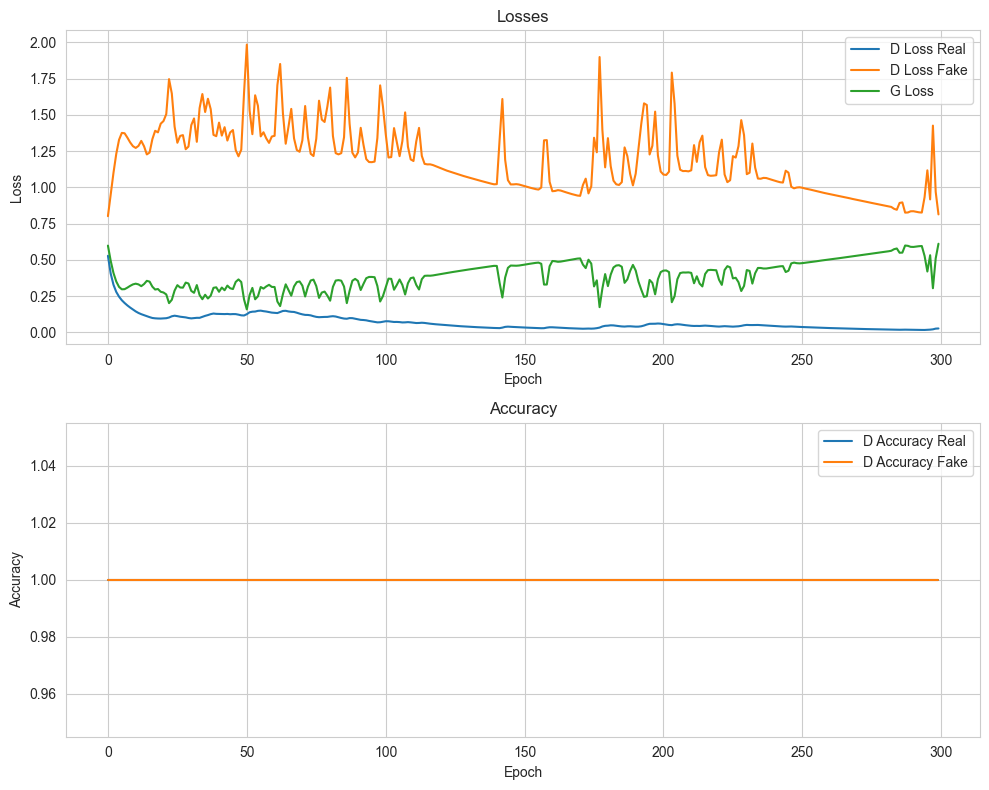

In [8]:
# 绘制指标图表
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(d_losses_real, label='D Loss Real')
plt.plot(d_losses_fake, label='D Loss Fake')
plt.plot(g_losses, label='G Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(d_accs_real, label='D Accuracy Real')
plt.plot(d_accs_fake, label='D Accuracy Fake')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# for epoch in range(epochs):
#     for _ in range(len(X_train) // batch_size):
#         # 生成噪声
#         noise = np.random.normal(0, 1, (batch_size, z_dim))
# 
#         # 生成随机条件标签
#         random_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
#         conditions_one_hot = tf.keras.utils.to_categorical(random_labels, num_classes)
# 
#         # 合并噪声和条件标签
#         generator_input = np.concatenate([noise, conditions_one_hot], axis=1)
# 
#         # 生成数据
#         generated_data = generator.predict(generator_input)
# 
#         # 从真实数据集中随机选择一批数据
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         real_data = X_train[idx]
# 
#         # 合并真实数据和相应的条件标签以准备判别器的输入
#         real_data_with_conditions = np.concatenate([real_data, conditions_one_hot], axis=1)
# 
#         # 训练判别器
#         d_loss_real = discriminator.train_on_batch(real_data_with_conditions, np.ones((batch_size, 1)))
#         d_loss_fake = discriminator.train_on_batch(np.concatenate([generated_data, conditions_one_hot], axis=1), np.zeros((batch_size, 1)))
# 
#         # 准备生成器（通过cGAN模型）训练的噪声和条件标签
#         g_loss = cgan.train_on_batch([noise, conditions_one_hot], np.ones((batch_size, 1)))
#         # 每个epoch结束时打印损失值
#         print(f"Epoch: {epoch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

   